<a href="https://colab.research.google.com/github/mikeacquaviva/APS360-Leukaemia-Classification/blob/main/cnn_leukemia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
import time
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
preprocessed_data_dir = ("/content/gdrive/MyDrive/APS360/processed")
classes = ['benign', 'early', 'pre', 'pro']
data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor()])
data_full = datasets.ImageFolder(preprocessed_data_dir, transform = data_transform)
print(len(data_full))
train  = len(data_full)*0.6
train = int(train) + 1
print(train)

val  = len(data_full)*0.2
val = int(val)
print(val)

train_full, val_full, test_full = random_split(data_full, [train, val, val], generator=torch.Generator().manual_seed(0)) #adding seed such that it produces the same data set each time
# print out some data stats
print('Num training images: ', len(train))
print('Num validation images: ', len(val))
print('Num test images: ', len(test))

KeyboardInterrupt: ignored

In [ ]:
data_dir = ("/content/gdrive/MyDrive/APS360/baseline/svm_images")
classes = ['benign', 'early', 'pre', 'pro']
data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor()])
data = datasets.ImageFolder(data_dir, transform = data_transform)
print(len(data))
train, val, test = random_split(data, [600, 105,  105], generator=torch.Generator().manual_seed(0)) #adding seed such that it produces the same data set each time
# print out some data stats
print('Num training images: ', len(train))
print('Num validation images: ', len(val))
print('Num test images: ', len(test))

810
Num training images:  600
Num validation images:  105
Num test images:  105


In [ ]:
# define dataloader parameters
batch_size = 32
num_workers = 1

# prepare data loaders
train_loader = 0
val_loader = 0
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=27, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=27, 
                                          num_workers=num_workers, shuffle=True)
print(len(train_loader))

23


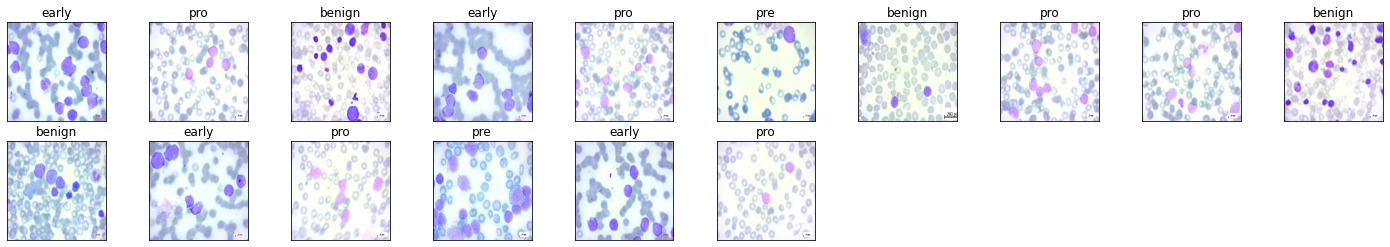

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(0) # set the random seed

In [ ]:
def get_data_loader(target_classes, batch_size):
  classes = ['benign', 'early', 'pre', 'pro']
  

In [ ]:
def leakyrelu(x):
  if(x>=0):
    return x
  else:
    return 0.01*x  

In [ ]:
#Convolutional Neural Network Architecture
class CNN_leaky(nn.Module):
    def __init__(self):
        super(CNN_leaky, self).__init__()
        self.name = "cnn"
        self.conv1 = nn.Conv2d(3, 5, 3) #in_channels, out_chanels, kernel_size, 
        #convolution neural network and have to specify the number of inner terminals and define the kernel size.
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride  
        #shift the entire image by 2 kernsls
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10 * 53 * 53, 32) 
        #self.fc2 = nn.Linear(64, 32) 
        self.fc3 = nn.Linear(32, 4) #which letter from a-i as the options for output, so 9 outputs 

    def forward(self, x):
        y = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(y))) #flatten the layer
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


In [ ]:
#Convolutional Neural Network Architecture
class CNN_MNISTClassifier(nn.Module):
    def __init__(self):
        super(CNN_MNISTClassifier, self).__init__()
        self.name = "cnn"
        self.conv1 = nn.Conv2d(3, 5, 3) #in_channels, out_chanels, kernel_size, 
        #convolution neural network and have to specify the number of inner terminals and define the kernel size.
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride  
        #shift the entire image by 2 kernsls
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10 * 53 * 53, 32) 
        #self.fc2 = nn.Linear(64, 32) 
        self.fc3 = nn.Linear(32, 4) #which letter from a-i as the options for output, so 9 outputs 

    def forward(self, x):
        y = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(y))) #flatten the layer
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


In [ ]:
#helper function; label, evaluate



def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        #labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [ ]:
def get_accuracy(model, data):

    correct = 0
    total = 0
    for imgs, labels in data:
        #print(imgs.size())
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
inputs, labels = data

ValueError: ignored

In [ ]:
from torch.utils.data import DataLoader, Dataset
def train(model, batch_size, learning_rate, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.98)
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    epoch = 0 # the number of iterations
    n = 0
    
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            n+=1
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            
        # save the current training information
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model,train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            #n += 1
        print(epoch, "acc:", train_acc[epoch])
    print("train_loader: ", n)     
    #draw_confusion_matrix(predicted_labels, actual_labels)
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
def accuracy_class(model):
  correct_pred = {classname: 0 for classname in classes}
  total = {classname: 0 for classname in classes}
  true_pos = {classname: 0 for classname in classes}
  for data in test_loader:
    images, labels = data
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    # determine correct prediction for each
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total[classes[label]] += 1
    draw_confusion_matrix(prediction, correct_pred)
  #print class accuracy for each
  for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total[classname]
    print(f'Accuracy for {classname:5s} : {accuracy:.5f} %')

0 acc: 0.4866666666666667
1 acc: 0.245
2 acc: 0.21166666666666667
3 acc: 0.3416666666666667
4 acc: 0.3516666666666667
5 acc: 0.4583333333333333
6 acc: 0.5783333333333334
7 acc: 0.5516666666666666
8 acc: 0.58
9 acc: 0.67
train_loader:  380


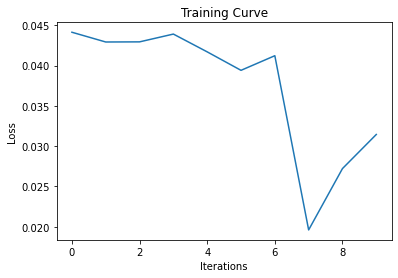

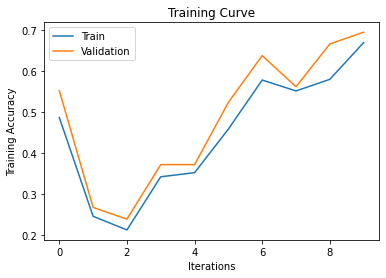

Final Training Accuracy: 0.67
Final Validation Accuracy: 0.6952380952380952


In [ ]:
net = CNN_leaky()

train(net, batch_size = 32, learning_rate = 0.01, num_epochs=10)

In [ ]:
leaky_net = net

In [ ]:
accuracy_class(leaky_net)

Accuracy for benign : 56.00000 %
Accuracy for early : 89.65517 %
Accuracy for pre   : 3.57143 %
Accuracy for pro   : 100.00000 %


In [ ]:
test_loader = torch.utils.data.DataLoader(test, batch_size=27, shuffle=True)
test_accuracy = get_accuracy(leaky_net, test_loader)
print("test accuracy:", test_accuracy)

test accuracy: 0.6095238095238096


0 acc: 0.25333333333333335
1 acc: 0.255
2 acc: 0.335
3 acc: 0.3416666666666667
4 acc: 0.4766666666666667
5 acc: 0.4633333333333333
6 acc: 0.58
7 acc: 0.58
8 acc: 0.5916666666666667
9 acc: 0.5916666666666667
10 acc: 0.44666666666666666
11 acc: 0.5916666666666667
12 acc: 0.5916666666666667
13 acc: 0.5916666666666667
14 acc: 0.5916666666666667
15 acc: 0.5916666666666667
16 acc: 0.4033333333333333
17 acc: 0.5916666666666667
18 acc: 0.5916666666666667
19 acc: 0.5916666666666667
20 acc: 0.5916666666666667
21 acc: 0.5916666666666667
22 acc: 0.5916666666666667
23 acc: 0.5916666666666667
24 acc: 0.5916666666666667
25 acc: 0.5916666666666667
26 acc: 0.5916666666666667
27 acc: 0.5916666666666667
28 acc: 0.5916666666666667
29 acc: 0.5916666666666667
train_loader:  1140


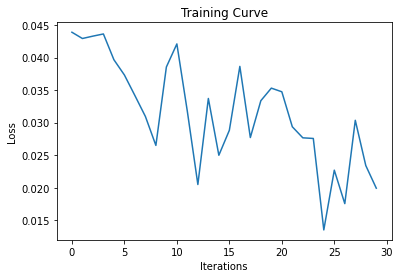

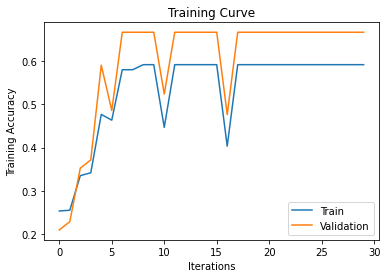

Final Training Accuracy: 0.5916666666666667
Final Validation Accuracy: 0.6666666666666666


In [ ]:
more_net = CNN_leaky()

train(more_net, batch_size = 32, learning_rate = 0.01, num_epochs=30)

In [ ]:
test_loader = torch.utils.data.DataLoader(test, batch_size=27, shuffle=True)
test_accuracy = get_accuracy(more_net, test_loader)
print("test accuracy:", test_accuracy)

test accuracy: 0.5904761904761905


0 acc: 0.3087431693989071
1 acc: 0.4344262295081967
2 acc: 0.30601092896174864
3 acc: 0.34972677595628415
4 acc: 0.45901639344262296
5 acc: 0.45901639344262296
6 acc: 0.45901639344262296
7 acc: 0.23770491803278687
8 acc: 0.5655737704918032
9 acc: 0.6284153005464481
10 acc: 0.34972677595628415
11 acc: 0.23770491803278687
12 acc: 0.40437158469945356
13 acc: 0.45901639344262296
14 acc: 0.45901639344262296
train_loader:  345


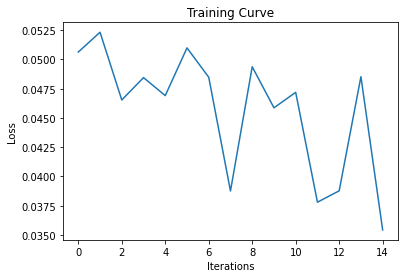

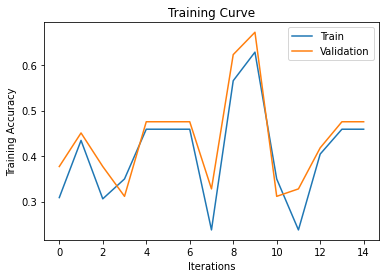

Final Training Accuracy: 0.45901639344262296
Final Validation Accuracy: 0.47540983606557374


In [ ]:
add_net = CNN_MNISTClassifier()

train(add_net, batch_size = 27, learning_rate = 0.01, num_epochs=15)

0 acc: 0.25333333333333335
1 acc: 0.255
2 acc: 0.27666666666666667
3 acc: 0.33666666666666667
4 acc: 0.19666666666666666
5 acc: 0.465
6 acc: 0.58
7 acc: 0.58
8 acc: 0.5916666666666667
9 acc: 0.5916666666666667
10 acc: 0.44166666666666665
11 acc: 0.5916666666666667
12 acc: 0.5916666666666667
13 acc: 0.5916666666666667


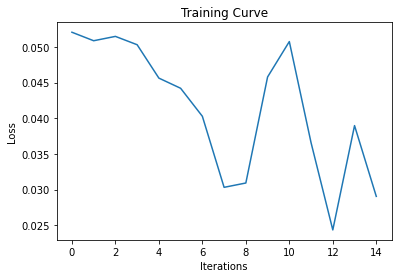

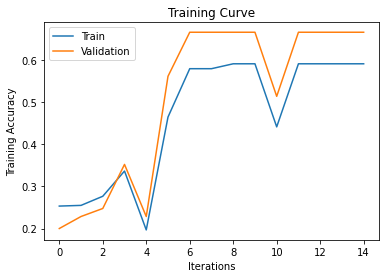

Final Training Accuracy: 0.5916666666666667
Final Validation Accuracy: 0.6666666666666666


In [ ]:
#increased the number of data from 400 in this set
net_810 = CNN_MNISTClassifier()

train(net_810, batch_size = 27, learning_rate = 0.01, num_epochs=15)

In [ ]:
test_loader = torch.utils.data.DataLoader(test, batch_size=27, shuffle=True)
test_accuracy = get_accuracy(net_810, test_loader)
print("test accuracy:", test_accuracy)

test accuracy: 0.5904761904761905


In [ ]:
#accuracy for net810 model
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
true_pos = {classname: 0 for classname in classes}
for data in test_loader:
    images, labels = data
    outputs = net_810(images)
    _, predictions = torch.max(outputs, 1)
    # collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for {classname:5s} : {accuracy:.5f} %')

Accuracy for benign : 40.00000 %
Accuracy for early : 100.00000 %
Accuracy for pre   : 0.00000 %
Accuracy for pro   : 100.00000 %


0 acc: 0.2791666666666667
1 acc: 0.22916666666666666
2 acc: 0.2791666666666667
3 acc: 0.2791666666666667
4 acc: 0.2791666666666667
5 acc: 0.2791666666666667
6 acc: 0.2791666666666667
7 acc: 0.2833333333333333
8 acc: 0.32083333333333336
9 acc: 0.2791666666666667
10 acc: 0.2791666666666667
11 acc: 0.2791666666666667
12 acc: 0.37083333333333335
13 acc: 0.3416666666666667
14 acc: 0.3416666666666667
15 acc: 0.25
16 acc: 0.4083333333333333
17 acc: 0.7041666666666667
18 acc: 0.5833333333333334
19 acc: 0.7291666666666666
20 acc: 0.9166666666666666
21 acc: 0.925
22 acc: 0.9458333333333333
23 acc: 0.9458333333333333
24 acc: 0.9541666666666667
25 acc: 0.9875
26 acc: 0.9625
27 acc: 0.9833333333333333
28 acc: 1.0
29 acc: 0.9958333333333333
30 acc: 0.9958333333333333
31 acc: 0.9958333333333333
32 acc: 0.9958333333333333
33 acc: 0.9958333333333333
34 acc: 1.0
35 acc: 1.0
36 acc: 1.0
37 acc: 1.0
38 acc: 1.0
39 acc: 1.0
40 acc: 1.0
41 acc: 1.0
42 acc: 1.0
43 acc: 1.0
44 acc: 1.0
45 acc: 1.0
46 acc: 1.0

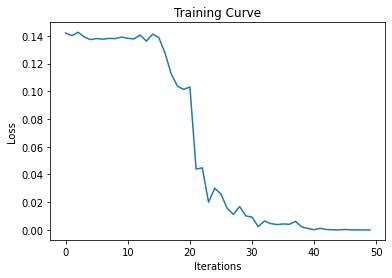

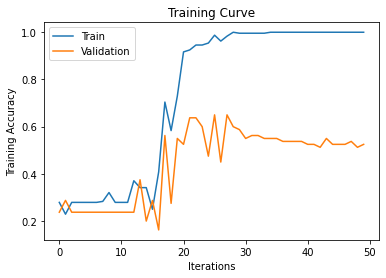

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.525


In [ ]:
#this was prior to when the model got stuck at ~27

net = CNN_MNISTClassifier()
train(net, batch_size = 10, learning_rate=0.01, num_epochs=50)

In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

for data in test_loader:
    images, labels = data
    outputs = net(images)
    _, predictions = torch.max(outputs, 1)
    # collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.5f} %')

#concerning results for a previous iteration of model with higher accuracy for certain classes

Accuracy for class: benign is 75.00000 %
Accuracy for class: early is 100.00000 %
Accuracy for class: pre   is 0.00000 %
Accuracy for class: pro   is 0.00000 %
